# Домашнее задание "Сегментация и детекция объектов"


Преподаватель: Наталья Баданина, Александр Миленькин
Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./digit-recognizer/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./digit-recognizer/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

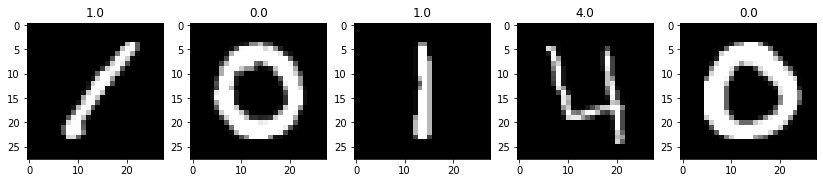

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

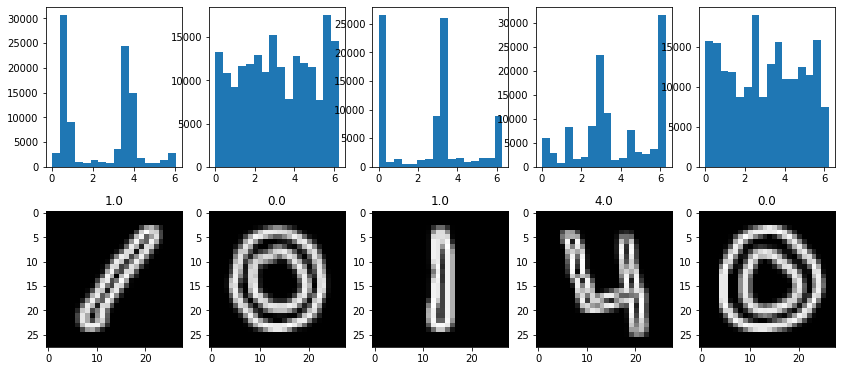

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
train_hist.shape

(42000, 16)

In [15]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [16]:
test_hist.shape

(28000, 16)

## Разбиваем выборку на обучение и валидацию

In [17]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Выберем алгоритм kNN для предсказания

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
model = KNeighborsClassifier(n_neighbors=15, metric='l2', weights='distance')
clf = model.fit(x_train, y_train)
y_pred = clf.predict(x_val)

## Оцениваем качество решения на валидационной выборке

In [20]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred))

Accuracy: 0.6144047619047619


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.38      0.44      0.41       816
         1.0       0.94      0.95      0.95       909
         2.0       0.48      0.35      0.40       846
         3.0       0.61      0.69      0.65       937
         4.0       0.70      0.66      0.68       839
         5.0       0.61      0.64      0.62       702
         6.0       0.42      0.42      0.42       785
         7.0       0.86      0.72      0.79       893
         8.0       0.49      0.52      0.50       835
         9.0       0.65      0.70      0.67       838

    accuracy                           0.61      8400
   macro avg       0.61      0.61      0.61      8400
weighted avg       0.62      0.61      0.61      8400



In [22]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[360   8  50  37  24  17 139   0 145  36]
 [  6 866   1   0  17   0   4   3   2  10]
 [ 79   0 296 162   9 125  59  12  87  17]
 [ 31   0  72 644   1  86  14   2  82   5]
 [ 35  26   3   2 556   2  81  30  12  92]
 [ 15   0  60 123   0 446   5   6  41   6]
 [185   3  51  13  67   6 326  17  58  59]
 [ 13  13  34   3  70  15  28 645   8  64]
 [183   0  34  57   4  34  52   3 435  33]
 [ 53   2  18  15  41   6  65  31  20 587]]


## Предсказания на тестовых данных

In [23]:
pred_test = clf.predict(test_hist)

## Визуализируем предсказания

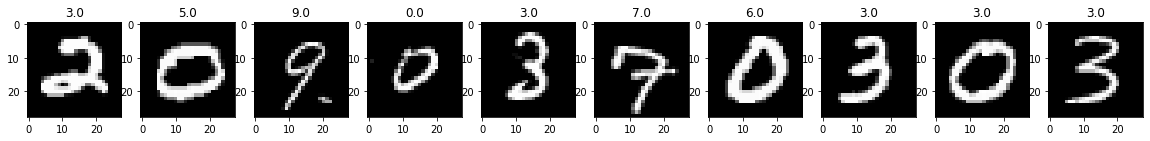

In [24]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [27]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [28]:
!head submit.txt

ImageId,Label
1,3
2,5
3,9
4,0
5,3
6,7
7,6
8,3
9,3
